# Inleveropgave 2: Model-Free Prediction and Control

## Model-Free Control

### Sources:
- https://www.baeldung.com/cs/ml-policy-reinforcement-learning
- https://github.com/djbyrne/MonteCarlo
- https://oneraynyday.github.io/ml/2018/05/24/Reinforcement-Learning-Monte-Carlo/#first-visit-monte-carlo

In [1]:
from typing import Tuple, List
from utils import Maze, show_policy
from collections import defaultdict

import random as rd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
start_state = (3, 2)
terminal_states = [(0, 3), (3, 0)]

rewards = np.array([[-1, -1, -1, 40],
                    [-1, -1, -10, -10],
                    [-1, -1, -1, -1],
                    [10, -2, -1, -1]])

# initialize the Maze
maze = Maze(rewards, terminal_states, start_state)

### On-policy first-visit Monte-Carlo Control

In [3]:
def epsilon_greedy_step(q_table, state, epsilon: float):
    """"""
    if epsilon > rd.random():
        # exploring
        action = rd.randint(0, len(q_table[state]) - 1)
    else:
        # choosing greedy
        action = np.argmax(q_table[state])
    
    return action
        

def generate_episode(env: Maze, q_table, epsilon: float):
    """"""
    steps = []  # holds Tuples with the states, actions and rewards
    pos = env.get_random_position()

    # break if the chosen state is a terminal state
    while pos not in env.end_states:
        
        # get the next action
        action = epsilon_greedy_step(q_table, pos, epsilon)
        next_actions = env.get_next_action_positions(pos)
        
        # get the reward of the state where the action leads to
        reward = env.R[next_actions[action]]
        
        # save the current step
        steps.append((pos, action, reward))

        # update the pos to the taken action
        pos = next_actions[action]
        
    # save the latest pos with all extra data
    steps.append((pos, (), 0))
    # print(steps)
    return steps

In [4]:
def on_policy_fv_mc_control(env: Maze, actions: List[str], discount: float = 0.9,
                            epsilon: float = 0.3, n_episodes: int = 10000):
    """"""
    # set up the qtable and the state-action returns
    policy_Q = defaultdict(lambda: np.zeros(len(actions)))
    mean_Q = defaultdict(lambda: np.zeros(len(actions)))
    state_returns = defaultdict(list)
    
    for _ in range(n_episodes):
        episode = generate_episode(env, policy_Q, epsilon)
        visited_qstates = []
        G = 0

        for state, action, reward in episode[::-1]:
            G = discount * G + reward

            if (state, action) not in visited_qstates:
                # the state-action haven't appeared yet
                visited_qstates.append((state, action))  # add state action pair to visited
                # update the return of the state action pair
                state_returns[(state, action)].append(G)
                # take the new mean of the state action pair
                mean_Q[state][action] = np.mean(state_returns[(state, action)])
                
                # set the a_star
                a_star = np.argmax(mean_Q[state])
                
                # update Q-table
                for index, action in enumerate(mean_Q[state]):
                    if index == a_star:
                        policy_Q[state][index] = 1 - epsilon + epsilon / len(policy_Q[state])
                    else:
                        policy_Q[state][index] = epsilon / len(policy_Q[state])

    return policy_Q      

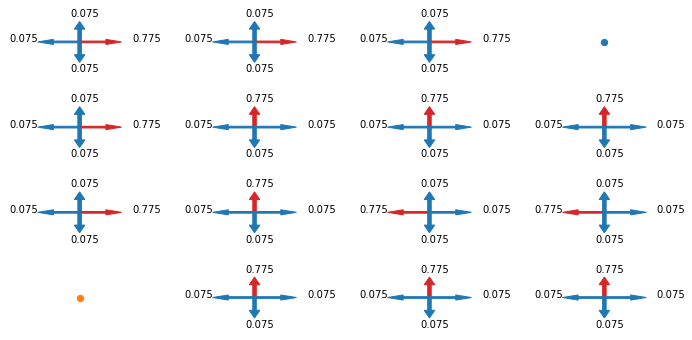

In [5]:
actions = ["up", "right", "left", "down"]

Q1 = on_policy_fv_mc_control(maze, actions, discount=1.0)
show_policy(maze, Q1)

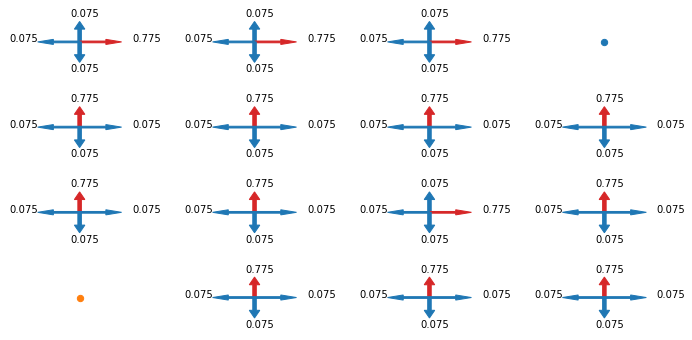

In [6]:
Q1 = on_policy_fv_mc_control(maze, actions, discount=0.9)
show_policy(maze, Q1)

### SARSA

In [7]:
def sarsa(env: Maze, actions: List[str], discount: float = 0.9, step_size: float = 0.1,
          epsilon: float = 0.3, n_episodes: int = 10000):
    """"""
    # set up the qtable and the state-action returns
    Q_table = defaultdict(lambda: np.zeros(len(actions)))
    
    for _ in range(n_episodes):
        state = env.get_random_position()
        
        # choose the action based on the current state (e-greedy)
        action = epsilon_greedy_step(Q_table, state, epsilon)
        
        while state not in env.end_states:

            # get the next state with the reward
            all_actions = env.get_next_action_positions(state)
            next_state = all_actions[action]
            reward = env.R[next_state]
            
            # choose greedily the next action of the following state
            next_action = epsilon_greedy_step(Q_table, next_state, epsilon)
            
            # calculate the Q-value
            Q_table[state][action] = Q_table[state][action] + step_size * (reward + discount * Q_table[next_state][next_action] - Q_table[state][action])
            
            # update the state and action
            state = next_state
            action = next_action

    return Q_table     

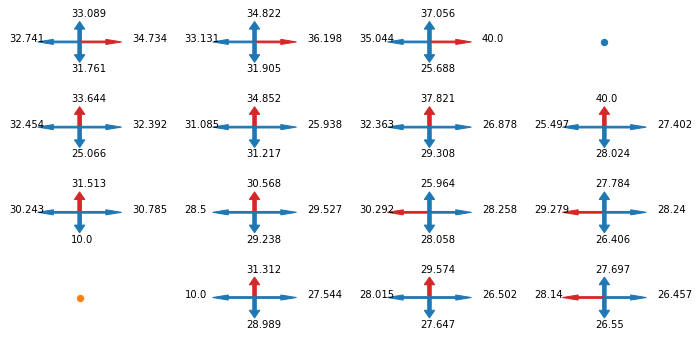

In [8]:
Q1 = sarsa(maze, actions, discount=1.0)
show_policy(maze, Q1)

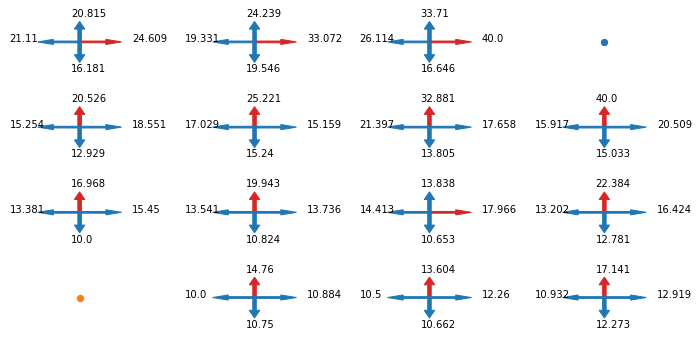

In [9]:
Q1 = sarsa(maze, actions, discount=0.9)
show_policy(maze, Q1)

### Q-Learning (SARSAMAX)

In [10]:
def q_learning(env: Maze, actions: List[str], discount: float = 0.9, step_size: float = 0.1,
          epsilon: float = 0.3, n_episodes: int = 10000):
    """"""
    # set up the qtable and the state-action returns
    Q_table = defaultdict(lambda: np.zeros(len(actions)))
    
    for _ in range(n_episodes):
        state = env.get_random_position()
        
        while state not in env.end_states:
            
            # choose the action based on the current state (e-greedy)
            action = epsilon_greedy_step(Q_table, state, epsilon)

            # get the next state with the reward
            all_actions = env.get_next_action_positions(state)
            next_state = all_actions[action]
            reward = env.R[next_state]
            
            # calculate the Q-value
            Q_table[state][action] = Q_table[state][action] + step_size * (reward + discount * np.amax(Q_table[next_state]) - Q_table[state][action])
            
            # update the state and action
            state = next_state

    return Q_table

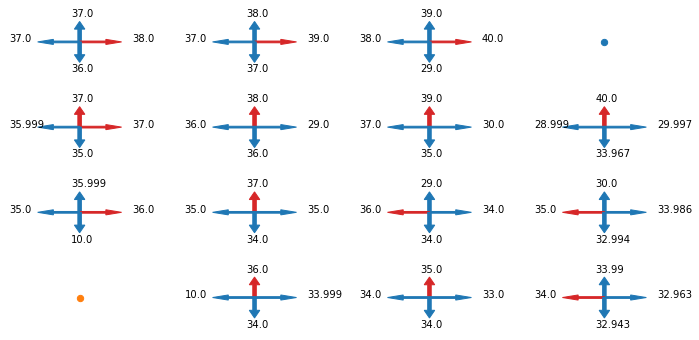

In [11]:
Q1 = q_learning(maze, actions, discount=1.0)
show_policy(maze, Q1)

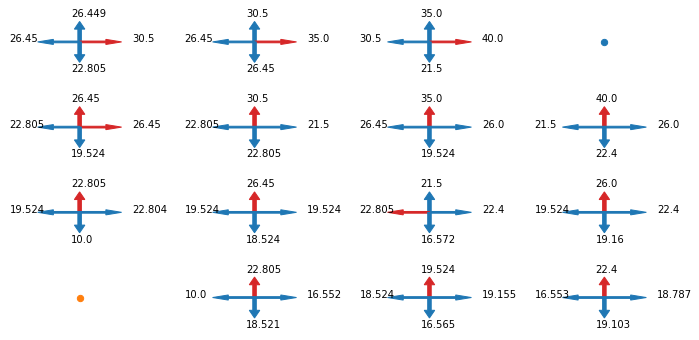

In [12]:
Q1 = q_learning(maze, actions, discount=0.9)
show_policy(maze, Q1)